# 10X `tcellmatch` Tutorial - Training
Make sure to run the previous notebook `10x_dataset_preprocessing.ipynb` before running this notebook. It also contains details on the dataset used in this tutorial and how it is processed. 

In [2]:
import pandas as pd
import tcellmatch.api as tm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_model_summary import summary
from torchmetrics import Accuracy
import torch
import os
import numpy as np
import wandb

# Load Data

This data is saved when running the previous notebook `10x_dataset_preprocessing.ipynb`.

In [3]:
ffn = tm.models.EstimatorFfn()
indir = '../tutorial_data/'
data = np.load(f"{indir}ffn_data_ds_continuous.npz")
ffn.x_train = data["x_train"]
ffn.covariates_train = data["covariates_train"]
ffn.y_train = data["y_train"]
ffn.x_test = data["x_test"]
ffn.covariates_test = data["covariates_test"]
ffn.y_test = data["y_test"]
ffn.clone_train = data["clone_train"]

These indices are used to split the data into train, validation, and test sets.

```python

In [4]:
ffn.load_idx(f'{indir}SAVED_IDX')

# Build Model
Here, we can build two models: a BiLSTM-based or self-attention-based model, detailed above.

Loss has the following possible parameters

1. Discrete
    1. Binary Crossentropy (param "bce")
    2. Weighted Binary Crossentropy (param "wbce")
    3. Categorical Crossentropy (param "cce")
2. Continuous
    1. MMD (param "mmd")
    2. Mean Squared error (param "mse")
    3. Poisson (param "pois")
    
Calling one of these creates the model and sets the ffn.model attribute.

In [5]:
model_name = 'CNN'
USE_BIND_COUNTS = True

In [6]:
if model_name.lower() == 'self-attention':
    ffn.build_self_attention(
        residual_connection=True,
        aa_embedding_dim=0,
        # hidden size of each attention layer
        attention_size=[5, 5],
        # number of heads at each layer
        attention_heads=[4, 4],
        optimizer='adam',
        lr=0.001,
        loss='mmd' if USE_BIND_COUNTS else 'wbce',
        label_smoothing=0
    )
elif model_name.lower() == 'bilstm':
    ffn.build_bilstm(
        # The depth of each bilstm layer (length of feature vector)
        topology = [10, 10, 10, 10],
        # Dimension of the linear amino acid embedding, ie number of 1x1 convolutional filters.
        # set to input dimension if aa_embedding_dim==0.
        aa_embedding_dim=0,
        optimizer='adam',
        lr=0.001,
        loss='pois' if USE_BIND_COUNTS else 'wcbe',
        label_smoothing=0,
        # whether to assume covariates in model architecture
        use_covariates=False,
        # whether we are predicting max binding categorical
        # or binding counts
        one_hot_y=not USE_BIND_COUNTS
    )
elif model_name.lower() == 'bigru':
    ffn.build_bigru(
        topology=[10, 10, 10],
        aa_embedding_dim=0,
        lr=0.005,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
        optimize_for_gpu= True,
    )
elif model_name.lower() == 'cnn':
    ffn.build_conv(
        n_conv_layers = 3,
        depth_final_dense = 3,
        filter_widths = [3, 5, 3],  # Filter widths for the three convolutional layers
        filters = [16, 32, 64],  # Output channels for the three convolutional layers
        pool_sizes = [2] * 3,  # Size of the pooling window
        pool_strides = [2] * 3,  # Stride for moving the pooling window,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
    )

# Train model
Train this model for 2 epochs     

In [7]:
EPOCHS = 2
batch_size = 100000
lr = 0.001
depth_final_dense = 3
wandb.init(
    # set the wandb project where this run will be logged
    project="TCR fitting",
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": model_name,
    "batch_size": batch_size,
    "depth_final_dense" : depth_final_dense,
    },
    reinit=True
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: jmboesen. Use `wandb login --relogin` to force relogin


In [8]:
train_curve, val_curve, antigen_loss, antigen_loss_val = ffn.train(
    epochs=EPOCHS,
    batch_size=batch_size,
    # tensorboard logs to this directory
    log_dir='training_runs',
    # if true, saves epochs x n_classes as ffn.antigen_loss
    # ijth element is loss of ith epoch on jth antigen
    # save_antigen_loss=True,
    allow_early_stopping=False,
    print_loss=True,
    lr_schedule_factor=0.99999,
    use_wandb=True
    )

Number of observations in evaluation data: 19
Number of observations in training data: 181
input conv torch.Size([181, 40, 26])
output conv torch.Size([181, 64, 5])
2.0137991905212402
input conv torch.Size([19, 40, 26])
output conv torch.Size([19, 64, 5])
input conv torch.Size([181, 40, 26])
output conv torch.Size([181, 64, 5])
1.9823182821273804
input conv torch.Size([19, 40, 26])
output conv torch.Size([19, 64, 5])


### Plot Loss Curves

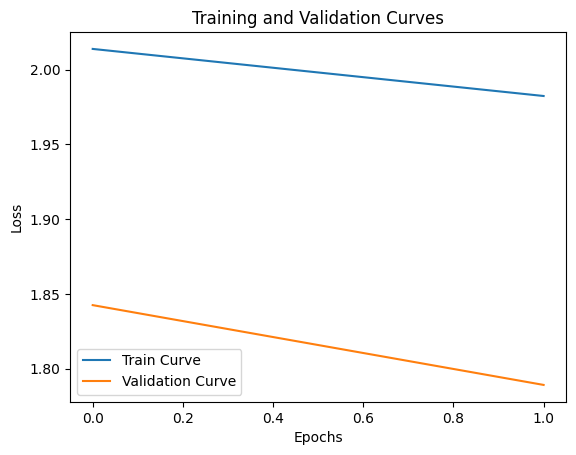

In [9]:
# Plotting the curves
plt.plot(train_curve, label='Train Curve')
plt.plot(val_curve, label='Validation Curve')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

## Get embeddings

Use this function to get the ouputs before our linear layer and store them for other use.

In [10]:
pred = ffn.model.get_embeddings(torch.ones(1, 1, 40, 26))

# Use model

## Evaluate on test set
This evaluates the data and returns binary and custom (i.e., based on how the model was built above) loss metrics

In [11]:
ffn.evaluate(
    # given k, returns loss only over the kth antigen in test
    antigen_col=None
)

input conv torch.Size([200, 40, 26])
output conv torch.Size([200, 64, 5])


{'test': {PoissonNLLLoss(): 2.048863410949707, 'Binary Accuracy': 34.065}}

## Save the model

In [12]:
os.makedirs(f'{indir}saved_model', exist_ok=True)
# save_yhat means save predictions
ffn.save_model_full(f'{indir}saved_model', save_yhat=True, save_train_data=False)

input conv torch.Size([128, 40, 26])
output conv torch.Size([128, 64, 5])
input conv torch.Size([72, 40, 26])
output conv torch.Size([72, 64, 5])


# Evaluate/Compare the Model
We predict the labels on test data and store to `ffn.predictions`

In [13]:
ffn.predict()
ffn.predictions.shape

input conv torch.Size([128, 40, 26])
output conv torch.Size([128, 64, 5])
input conv torch.Size([72, 40, 26])
output conv torch.Size([72, 64, 5])


(200, 50)

### Create Confusion Matrix
This is only applicable, of course, if you've used the one-hot encoded maximum binding y-data. If it is, you can use this to also compare with the original tcellmatch in torch

In [14]:
if not USE_BIND_COUNTS:
    true_labels = np.argmax(ffn.y_test, axis=1)
    predicted_labels = np.argmax(ffn.predictions, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Reproduce evaluation in a new instance of model w/ same weights

We load the model, with weights and data included, and evaluate and predict on the test data

In [15]:
ffn2 = tm.models.EstimatorFfn()
ffn2.load_model_full(fn=f'{indir}saved_model', load_train_data=False)
print(ffn2.evaluate(test_only=True))
ffn2.predict()

input conv torch.Size([200, 40, 26])
output conv torch.Size([200, 64, 5])
{'test': {PoissonNLLLoss(): 2.048863410949707, 'Binary Accuracy': 34.065}}
input conv torch.Size([128, 40, 26])
output conv torch.Size([128, 64, 5])
input conv torch.Size([72, 40, 26])
output conv torch.Size([72, 64, 5])


## Plot Residuals
This function outputs a MatPlotLib histogram of the residuals of the given antigen index (here `0`) over the test data. `predict()` must be called first to generate our test predictions.

In [16]:
# %% [collapsed] Import list of target binders and non-binders
target_ids = [
    'A0101_VTEHDTLLY_IE-1_CMV',
    'A0201_KTWGQYWQV_gp100_Cancer',
    'A0201_ELAGIGILTV_MART-1_Cancer',
    'A0201_CLLWSFQTSA_Tyrosinase_Cancer',
    'A0201_IMDQVPFSV_gp100_Cancer',
    'A0201_SLLMWITQV_NY-ESO-1_Cancer',
    'A0201_KVAELVHFL_MAGE-A3_Cancer',
    'A0201_KVLEYVIKV_MAGE-A1_Cancer',
    'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase',
    'A0201_LLDFVRFMGV_EBNA-3B_EBV',
    'A0201_LLMGTLGIVC_HPV-16E7_82-91',
    'A0201_CLGGLLTMV_LMP-2A_EBV',
    'A0201_YLLEMLWRL_LMP1_EBV',
    'A0201_FLYALALLL_LMP2A_EBV',
    'A0201_GILGFVFTL_Flu-MP_Influenza',
    'A0201_GLCTLVAML_BMLF1_EBV',
    'A0201_NLVPMVATV_pp65_CMV',
    'A0201_ILKEPVHGV_RT_HIV',
    'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2',
    'A2402_CYTWNQMNL_WT1-(235-243)236M_Y',
    'A0201_RTLNAWVKV_Gag-protein_HIV',
    'A0201_KLQCVDLHV_PSA146-154',
    'A0201_LLFGYPVYV_HTLV-1',
    'A0201_SLFNTVATL_Gag-protein_HIV',
    'A0201_SLYNTVATLY_Gag-protein_HIV',
    'A0201_SLFNTVATLY_Gag-protein_HIV',
    'A0201_RMFPNAPYL_WT-1',
    'A0201_YLNDHLEPWI_BCL-X_Cancer',
    'A0201_MLDLQPETT_16E7_HPV',
    'A0301_KLGGALQAK_IE-1_CMV',
    'A0301_RLRAEAQVK_EMNA-3A_EBV',
    'A0301_RIAAWMATY_BCL-2L1_Cancer',
    'A1101_IVTDFSVIK_EBNA-3B_EBV',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV',
    'B3501_IPSINVHHY_pp65_CMV',
    'A2402_AYAQKIFKI_IE-1_CMV',
    'A2402_QYDPVAALF_pp65_CMV',
    'B0702_QPRAPIRPI_EBNA-6_EBV',
    'B0702_TPRVTGGGAM_pp65_CMV',
    'B0702_RPPIFIRRL_EBNA-3A_EBV',
    'B0702_RPHERNGFTVL_pp65_CMV',
    'B0801_RAKFKQLL_BZLF1_EBV',
    'B0801_ELRRKMMYM_IE-1_CMV',
    'B0801_FLRGRAYGL_EBNA-3A_EBV',
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC',
]
nc_cols = [
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC'
]

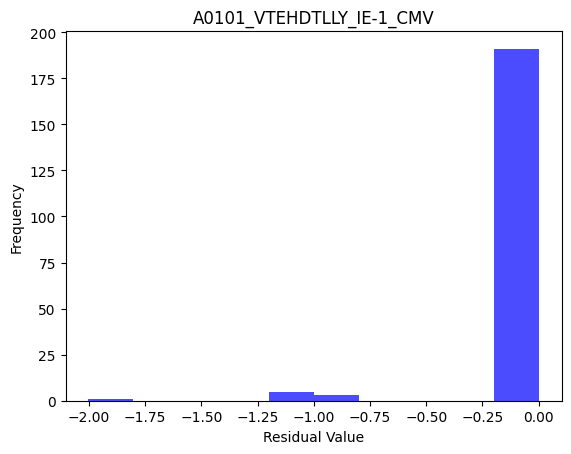

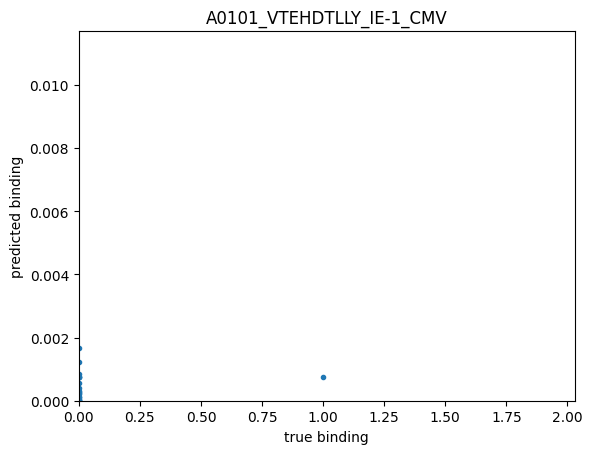

In [17]:
ffn.plot_residuals(antigen_idx=0, target_ids=target_ids)
ffn.compare_preds(antigen_idx=0, target_ids=target_ids)